In [4]:
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
import scipy.spatial.distance as ssd

from scipy.io import loadmat
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from statsmodels.formula.api import logit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score

# MAT 388E HW3

## Q1

This is going to be an image classification problem. For this problem we are going to use [the corrected Indian Pines Dataset](https://www.ehu.eus/ccwintco/index.php?title=Hyperspectral_Remote_Sensing_Scenes#Indian_Pines).

1. Download the data (both the corrected dataset and the ground-truth dataset) into a subdirectory called `data`, and ingest it as I did in [Lecture 8](https://github.com/kaygun/2022-Fall-388E/blob/main/lecture-8.ipynb).
2. Instead of using a categorical target variable with 17 classes, from the ground-truth data you ingested create 17 binary classifiers using scikit-learn's [`LabelBinarizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html).

For the steps 3,4, and 5 below write an appropriate function that takes a model type ('LR','SVM', or 'KNN'), the independent variable (the dataset you ingested above) and binary target variable and returns the accuracy score of a properly constructed model given by a 10-fold cross-validation. Use scikitlearn's [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html) routines. Record your results from Steps 2,3 and 4 in a pandas data frame.  

3. Construct a logistic regression model for each of the 17 class, and evaluate them using a 10-fold cross-validation. 
4. Construct an SVM model for each of the 17 class, and evaluate them using a 10-fold cross-validation. 
5. Construct a KNN model for each of the 17 class and evaluate them using a 10-fold cross-validation. You must determine what would be an appropriate K-value for each class separately, or you may decide to use a single K-value.
6. Display and analyze your cross-validation results in a table. What is the best model overall? What is the best model for each class? 

In [52]:
def model_vld(model,independent,target):
    X_train, X_test, y_train, y_test = train_test_split(independent,target,train_size=0.75)
    kf = KFold(n_splits=10)

    if model == "LR":
        model = LogisticRegression(max_iter=1500, solver="lbfgs").fit(X_train,y_train)
    
    if model == "SVM":
        model = SVC(kernel='linear',C=2.0).fit(X_train,y_train)
    
    if model == "KNN":
        
        Ks = 10
        mean_acc = np.zeros((Ks-1))
        
        for n in range (1, Ks) :
            model = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
            y_pred = model.predict(X_test)
            mean_acc[n-1] = accuracy_score(y_test, y_pred)
        
        best_k = np.where(mean_acc == np.array(mean_acc).max())
        print(best_k[0][0]+1)

        model = KNeighborsClassifier(n_neighbors = best_k[0][0]+1).fit(X_train,y_train)
        
    y_pred = model.predict(X_test)
    scores = cross_val_score(model, X_test, y_pred, cv=kf)
    
    return [scores.mean(),scores.std()]


In [43]:
pine = loadmat('./data/Indian_pines_corrected.mat')['indian_pines_corrected']
pine_gt = loadmat('./data/Indian_pines_gt.mat')['indian_pines_gt']

X = pine.reshape((145*145,200))
y = pine_gt.reshape(145*145)

In [44]:
encoder = LabelBinarizer()
ys = encoder.fit_transform(y)
ys.shape

(21025, 17)

In [45]:
def df_create(model):
    #   mean,std
    arr=[[],[]]

    for i in range(17):
        dt = model_vld(model,X,ys[:,i])
        arr[0].append(dt[0])  
        arr[1].append(dt[1])

    arr

    data = {'means_'+str(model): arr[0], "std_"+str(model) : arr[1]}
    df = pd.DataFrame(data)

    return df


In [ ]:
lr = df_create("LR")

In [9]:
svm = df_create("SVM")
svm

In [ ]:
svm.info()

In [ ]:
knn = df_create("KNN")

In [72]:
res = pd.concat([lr,svm,knn],axis=1)
res

,means_LR,std_LR,means_SVM,std_SVM,means_KNN,std_KNN
0,0.968803,0.003207,0.973942,0.009913,0.971463,0.005331
1,0.998669,0.000871,NaN,NaN,0.998859,0.001521
2,0.982689,0.004615,NaN,NaN,0.982309,0.006963
3,0.983640,0.005531,NaN,NaN,0.985545,0.006199
4,0.991251,0.003086,NaN,NaN,0.993342,0.001951
5,0.991628,0.003921,NaN,NaN,0.990108,0.003690
6,0.987634,0.003538,NaN,NaN,0.988776,0.004375
7,0.998669,0.001217,NaN,NaN,0.998859,0.001261
8,0.993913,0.002796,0.992961,0.002829,0.993914,0.001861
9,0.998288,0.001024,NaN,NaN,0.998479,0.001141


## Q2

For this question, we are going to analyze some [NBA datasets](https://sports-statistics.com/sports-data/nba-basketball-datasets-csv-files/). Specifically, we look at the season 2018-2019.

In [6]:
NBA = pd.read_csv('https://sports-statistics.com/database/basketball-data/nba/2018-19_pbp.csv')
NBA.columns

Index(['Unnamed: 0', 'EVENTMSGACTIONTYPE', 'EVENTMSGTYPE', 'EVENTNUM',
       'GAME_ID', 'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION', 'PCTIMESTRING',
       'PERIOD', 'PERSON1TYPE', 'PERSON2TYPE', 'PERSON3TYPE', 'PLAYER1_ID',
       'PLAYER1_NAME', 'PLAYER1_TEAM_ABBREVIATION', 'PLAYER1_TEAM_CITY',
       'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_NICKNAME', 'PLAYER2_ID',
       'PLAYER2_NAME', 'PLAYER2_TEAM_ABBREVIATION', 'PLAYER2_TEAM_CITY',
       'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_NICKNAME', 'PLAYER3_ID',
       'PLAYER3_NAME', 'PLAYER3_TEAM_ABBREVIATION', 'PLAYER3_TEAM_CITY',
       'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_NICKNAME', 'SCORE', 'SCOREMARGIN',
       'VISITORDESCRIPTION', 'WCTIMESTRING'],
      dtype='object')

1. Using the columns `PLAYER1_TEAM_ABBREVIATION`, `PLAYER2_TEAM_ABBREVIATION`, `PLAYER3_TEAM_ABBREVIATION` construct a 30x30 matrix that has the total number of interactions the teams had with each other during the season.
2. Using the matrix you constructed in the previous step, construct a hiearchical clustering model and split the NBA teams into 2 clusters.
3. NBA Teams are split into 2 Leagues: [The Eastern Conference](https://en.wikipedia.org/wiki/Eastern_Conference_(NBA)) and [The Western Conference](https://en.wikipedia.org/wiki/Western_Conference_(NBA)). What is the relationships of the clusters with these leagues. Explain.
4. Using the columns `PLAYER1_NAME`, `PLAYER2_NAME`, `PLAYER3_NAME` construct a matrix (don't display) that has the total number of interactions the players had during the season with each other. Then keep only the players that has a total of 500 or more interactions during the season, and display the resulting matrix.
5. Using the matrix you constructed in the previous step, draw a dendrogram of the players (with a total of 500 or more interactions), and decide how many clusters are appropriate.
6. Using the matrix and the dendrogram you constructed in the previous steps, construct a hiearchical clustering model for the players and split them into the number of clusters you determined above.

In [128]:
fs = NBA.pivot_table(index=['PLAYER1_TEAM_ABBREVIATION'],columns=['PLAYER2_TEAM_ABBREVIATION'])["EVENTMSGACTIONTYPE"].fillna(0)
ft = NBA.pivot_table(index=['PLAYER1_TEAM_ABBREVIATION'],columns=['PLAYER3_TEAM_ABBREVIATION'])["EVENTMSGACTIONTYPE"].fillna(0)
st = NBA.pivot_table(index=['PLAYER2_TEAM_ABBREVIATION'],columns=['PLAYER3_TEAM_ABBREVIATION'])["EVENTMSGACTIONTYPE"].fillna(0)

In [143]:
result = np.array(fs) + np.array(ft)+ np.array(st)  


In [171]:
temp = fs.columns.copy()
east = ["ATL","BOS","BKN","CHA","CHI","CLE","DET","IND","MIA","MIL","NYK","ORL","PHI","TOR","WAS"]
west = list(set(temp) - set(east))

team_names = []

for i in range(15):
    team_names.append(east[i]+"_EST")
    team_names.append(west[i]+"_WST")


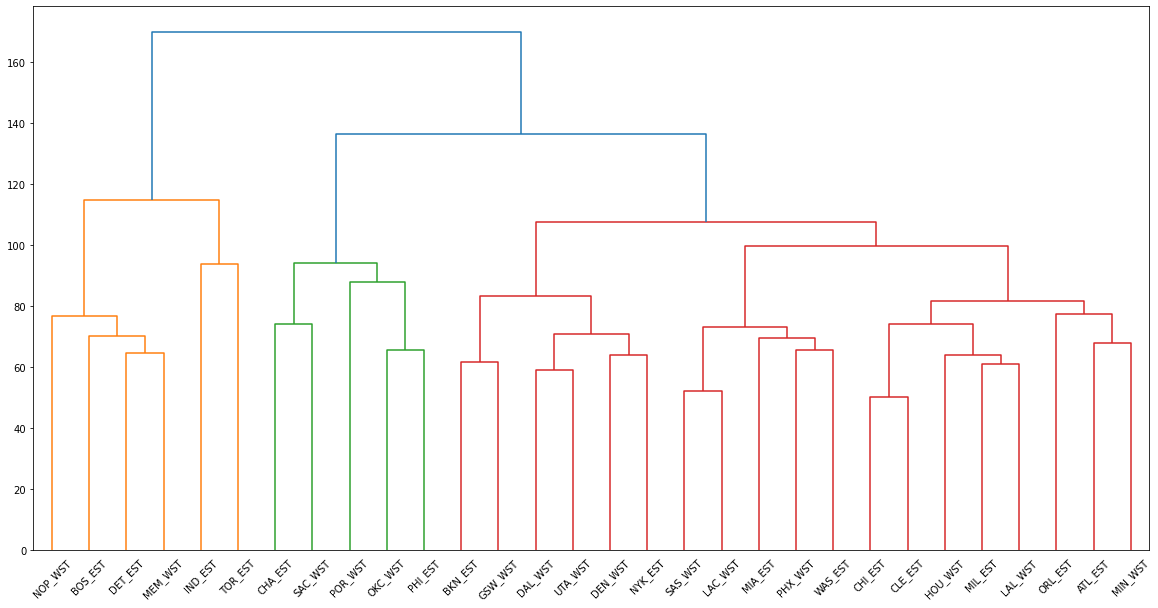

In [181]:
plt.figure(figsize=(20,10))
den = hc.dendrogram(hc.linkage(result, method='ward'), orientation='top',labels=team_names)

In [55]:
NBA.pivot_table(index=['PLAYER1_NAME'],columns=['PLAYER2_NAME'])

EVENTMSGACTIONTYPE                                       \
PLAYER2_NAME          Aaron Gordon Aaron Holiday Abdel Nader Al Horford   
PLAYER1_NAME                                                              
Aaron Gordon                   NaN           NaN         NaN        1.0   
Aaron Holiday                  NaN           NaN         NaN        NaN   
Abdel Nader                    2.0           NaN         NaN        NaN   
Al Horford                     NaN           NaN         NaN        NaN   
Al-Farouq Aminu                1.0           NaN         NaN        NaN   
...                            ...           ...         ...        ...   
Zach LaVine                    NaN           NaN         NaN        NaN   
Zach Lofton                    NaN           NaN         NaN        NaN   
Zaza Pachulia                  NaN           1.0         NaN        NaN   
Zhaire Smith                   NaN           NaN         NaN        NaN   
Zhou Qi                        NaN           NaN         NaN        NaN   

                                                                       \
PLAYER2_NAME    Al-Farouq Aminu Alan Williams Alec Burks Alex Abrines   
PLAYER1_NAME                                                            
Aaron Gordon                4.0           NaN        NaN          NaN   
Aaron Holiday               NaN           NaN        NaN          NaN   
Abdel Nader                 NaN           NaN        2.0          NaN   
Al Horford                  1.0           NaN        1.0          NaN   
Al-Farouq Aminu             NaN           NaN        NaN          NaN   
...                         ...           ...        ...          ...   
Zach LaVine                 2.0           NaN        5.0          NaN   
Zach Lofton                 NaN           NaN        NaN          NaN   
Zaza Pachulia               NaN           NaN        NaN          4.0   
Zhaire Smith                NaN           NaN        NaN          NaN   
Zhou Qi                     NaN           NaN        NaN          NaN   

                                       ...      Unnamed: 0              \
PLAYER2_NAME    Alex Caruso  Alex Len  ... Wilson Chandler Yante Maten   
PLAYER1_NAME                           ...                               
Aaron Gordon            NaN  1.500000  ...             NaN         NaN   
Aaron Holiday           NaN       NaN  ...             NaN         NaN   
Abdel Nader             NaN       NaN  ...             NaN         NaN   
Al Horford              NaN       NaN  ...             NaN         NaN   
Al-Farouq Aminu         NaN       NaN  ...             NaN         NaN   
...                     ...       ...  ...             ...         ...   
Zach LaVine             NaN  1.666667  ...             NaN         NaN   
Zach Lofton             NaN       NaN  ...             NaN         NaN   
Zaza Pachulia           2.0       NaN  ...             NaN         NaN   
Zhaire Smith            NaN       NaN  ...             NaN         NaN   
Zhou Qi                 NaN       NaN  ...             NaN         NaN   

                                                                     \
PLAYER2_NAME    Yogi Ferrell Yuta Watanabe Zach Collins Zach LaVine   
PLAYER1_NAME                                                          
Aaron Gordon             NaN           NaN   136.000000       164.0   
Aaron Holiday            NaN           NaN          NaN         NaN   
Abdel Nader            144.0           NaN   256.000000         NaN   
Al Horford               NaN           NaN          NaN         NaN   
Al-Farouq Aminu          NaN           NaN   182.890625         NaN   
...                      ...           ...          ...         ...   
Zach LaVine              NaN           NaN          NaN         NaN   
Zach Lofton              NaN           NaN          NaN         NaN   
Zaza Pachulia            NaN           NaN   131.000000       160.0   
Zhaire Smith             NaN           NaN          N

In [7]:
p12 = NBA.pivot_table(index=['PLAYER1_NAME'],columns=['PLAYER2_NAME'])["EVENTMSGACTIONTYPE"].fillna(0)
p13 = NBA.pivot_table(index=['PLAYER1_NAME'],columns=['PLAYER3_NAME'])["EVENTMSGACTIONTYPE"].fillna(0)
p23 = NBA.pivot_table(index=['PLAYER2_NAME'],columns=['PLAYER3_NAME'])["EVENTMSGACTIONTYPE"].fillna(0)


In [8]:
p12

PLAYER2_NAME,Aaron Gordon,Aaron Holiday,Abdel Nader,Al Horford,Al-Farouq Aminu,Alan Williams,Alec Burks,Alex Abrines,Alex Caruso,Alex Len,...,Wilson Chandler,Yante Maten,Yogi Ferrell,Yuta Watanabe,Zach Collins,Zach LaVine,Zach Lofton,Zaza Pachulia,Zhaire Smith,Zhou Qi
PLAYER1_NAME,,,,,,,,,,,,,,,,,,,,,
Aaron Gordon,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,1.500000,...,0.0,0.0,0.0,0.0,2.000000,2.0,0.0,0.0,0.0,0.0
Aaron Holiday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0
Abdel Nader,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.000000,...,0.0,0.0,2.0,0.0,1.500000,0.0,0.0,0.0,0.0,0.0
Al Horford,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.0,0.0,0.0
Al-Farouq Aminu,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.140625,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zach LaVine,0.0,0.0,0.0,0.0,2.0,0.0,5.0,0.0,0.0,1.666667,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.5,0.0,0.0
Zach Lofton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Zaza Pachulia,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.000000,...,0.0,0.0,0.0,0.0,1.500000,2.0,0.0,0.0,0.0,0.0


In [123]:
names = pd.concat([NBA['PLAYER1_NAME'], NBA['PLAYER2_NAME'],NBA['PLAYER3_NAME']], axis=0)
names = names.dropna()
names = names.reset_index(drop=True)
names = names.unique()

df = pd.DataFrame(data=np.zeros((len(names),len(names))),columns=names, index=names)

df

,Deandre Ayton,Josh Jackson,James Harden,Mikal Bridges,Devin Booker,Elie Okobo,James Ennis III,PJ Tucker,Kenneth Faried,Chris Paul,...,LaSalle Thompson,Terry Mills,Arvydas Sabonis,Anthony Miller,Nick Van Exel,Fred Hoiberg,Dell Demps,Kobi Simmons,John Holland,Tyler Ulis
Deandre Ayton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Josh Jackson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
James Harden,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mikal Bridges,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Devin Booker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fred Hoiberg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dell Demps,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Kobi Simmons,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
John Holland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


sorry i didnt get the question 